In [1]:
from __future__ import division, print_function
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import sys
sys.path.append('/Users/roz18/Documents/git/qp')
sys.path.append('/Users/roz18/Documents/git/PZDC1paper/metric_scripts')
import qp
sys.path.append('/Users/roz18/git/Python/user_modules')
from readEazyBinary import readpz
import individual_metrics as inmet
from astropy.table import Table
%matplotlib inline

In [2]:
path = '/Users/roz18/Dropbox/Work/mini-projects/Buzzard-EAZY/inputs_Buzzard_training/OUTPUT_medium_grid'

cat = Table.read('/Users/roz18/Documents/Data/mini-projects/buzzard_photo-z/Final_Buzzard_training_file.fits')
print(len(cat))

# Gold sample cut
mask = cat['LSSTi']<25.3
print(np.sum(mask))

# Remove objects with invalide flux measurements
mask = mask & (cat['LSSTu']!=99.) & (cat['LSSTg']!=99.) & (cat['LSSTr']!=99.) & \
       (cat['LSSTi']!=99.) & (cat['LSSTz']!=99.) & (cat['LSSTy']!=99.)
print(np.sum(mask))

# redshift range
zmin = 0.
zmax = 2.0
mask = mask & (cat['redshift']>zmin) & (cat['redshift']<zmax)
print(np.sum(mask))
cat = cat[mask]
zspec = cat['redshift']

111171
44410
43486
43486


In [3]:
# Load p(z) data
pz_dict = readpz(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY=path, APPLY_PRIOR=False)
# Redshift grid
zgrid = pz_dict['zgrid']
# p(z)
pz = pz_dict['pz'][mask]
# prior = pz_dict['prior'][mask]
# chi squared
chi2 = pz_dict['chi2'][mask]

In [4]:
# Downsampling
size = 1000
np.random.seed(1842)
idx = np.random.choice(len(pz), size=size, replace=False)
pz = pz[idx]
zspec = zspec[idx]

In [5]:
approx_pdf = qp.Ensemble(len(pz),gridded=(zgrid,pz), vb=False)
testme = inmet.EvaluateMetric(approx_pdf, zspec)

made the pool of 4 in 0.0308289527893
made the catalog in 2.32120990753


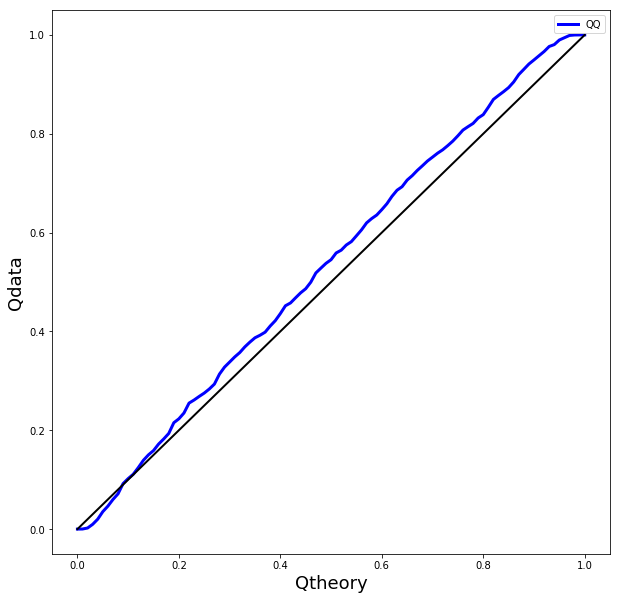

In [6]:
qqplot = testme.QQplot(using='gridded',dx=0.0001,Nquants=101)

In [7]:
pit = testme.PIT()

In [8]:
print(np.max(pit))
print(np.argmax(pit))

1.00000913418
872


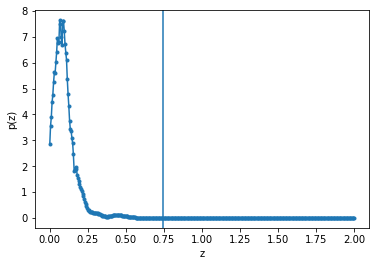

In [9]:
plt.plot(zgrid, pz[872], '.-')
plt.axvline(zspec[872])
plt.xlabel('z')
plt.ylabel('p(z)')
plt.show()

In [10]:
# Check if integral is 1
np.trapz(pz[451], zgrid)

1.0

__CvM and AD statistics and pvalues:__

In [11]:
testme.CvM(using='gridded')

(1.4860452260895303, 0.00018439091688082776)

In [12]:
testme.AD(using='gridded', vmin=0.005, vmax=0.995)

(4.4396937225318425, 0.005332880563337028)

In [13]:
print('# of objects outside 0.5%-99.5% limit:', np.sum((pit>0.005) | (pit<0.995)))

# of objects outside 0.5%-99.5% limit: 1


---------
__My own code for QQ plots:__

In [24]:
# redshift range
zmin = 0.
zmax = 2.0

# Interpolation: insert points between the grid points
# set the number of iterations
n_iterations = 5
zgrid_fine = zgrid.copy()
for index in range(n_iterations):
    zgrid1 = np.zeros(len(zgrid_fine)*2-1)
    zgrid1[::2] = zgrid_fine
    zgrid1[1::2] = (zgrid_fine[:-1]+zgrid_fine[1:])/2
    zgrid_fine = zgrid1.copy()
    
pz_fine = np.zeros((len(pz), len(zgrid_fine)))
for index in range(len(pz)):
    pz_interp = scipy.interpolate.interp1d(zgrid, pz[index], kind='linear')
    pz_fine[index] = pz_interp(zgrid_fine)
    print('\r{}'.format(index), end='')

999

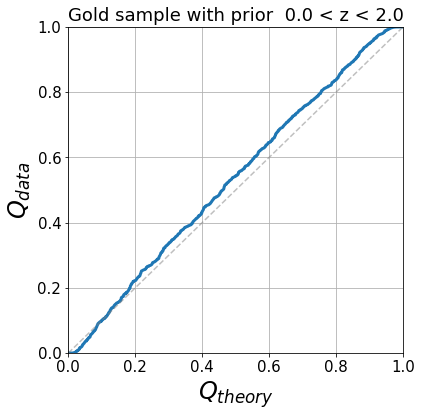

In [25]:
# Using PIT values from previous scripts

zgrid1 = np.ones((len(pz_fine), len(zgrid_fine)))*zgrid_fine
t = np.array(zgrid1< zspec[:, None], dtype=float)
# set p(z) to zero for z>zspec
pz1 = pz_fine * t
# Integrate to get CDF values at zspec
cdfs = np.trapz(pz1, zgrid_fine, axis=1)
# Sort CDF values to get quantiles
q_data = np.sort(cdfs)
q_theory = np.linspace(0.5/len(q_data), 1-0.5/len(q_data), len(q_data))

x = np.linspace(0, 1)
plt.figure(figsize=(6,6))
plt.plot(q_theory, q_data, linewidth=3)
plt.plot(x, x, '--', color='grey', alpha=0.5)
plt.title('Gold sample with prior  {} < z < {}'.format(zmin, zmax), fontsize=18)
plt.xlabel(r'$Q_{theory}$', fontsize=24)
plt.ylabel(r'$Q_{data}$', fontsize=24)
plt.tick_params(labelsize=15)
plt.axis([0, 1., 0, 1.])
plt.grid()
plt.show()

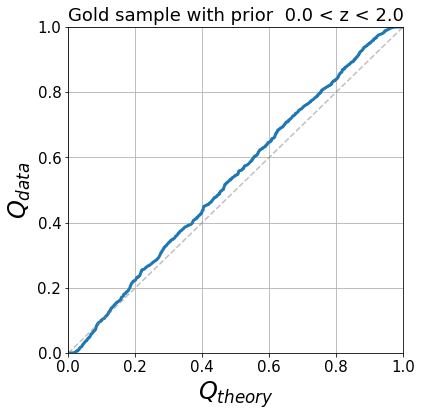

In [26]:
zgrid1 = np.ones((len(pz_fine), len(zgrid_fine)))*zgrid_fine
t = np.array(zgrid1< zspec[:, None], dtype=float)
# set p(z) to zero for z>zspec
pz1 = pz_fine * t
# Integrate to get CDF values at zspec
cdfs = np.trapz(pz1, zgrid_fine, axis=1)
# Sort CDF values to get quantiles
q_data = np.sort(pit)
q_theory = np.linspace(0.5/len(q_data), 1-0.5/len(q_data), len(q_data))

x = np.linspace(0, 1)
plt.figure(figsize=(6,6))
plt.plot(q_theory, q_data, linewidth=3)
plt.plot(x, x, '--', color='grey', alpha=0.5)
plt.title('Gold sample with prior  {} < z < {}'.format(zmin, zmax), fontsize=18)
plt.xlabel(r'$Q_{theory}$', fontsize=24)
plt.ylabel(r'$Q_{data}$', fontsize=24)
plt.tick_params(labelsize=15)
plt.axis([0, 1., 0, 1.])
plt.grid()
plt.show()

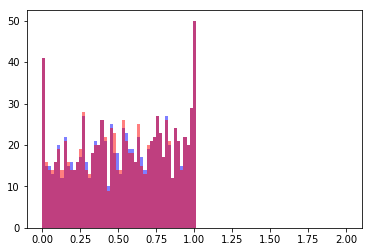

In [27]:
plt.hist(pit, bins=np.linspace(0, 2, 100), alpha=0.5, color='b')
plt.hist(cdfs, bins=np.linspace(0, 2, 100), alpha=0.5, color='r')
plt.show()

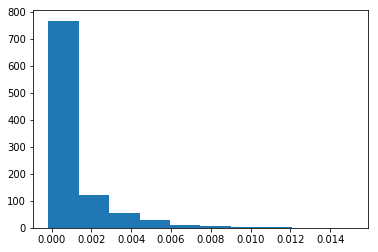

In [28]:
plt.hist(pit-cdfs)
plt.show()